# In this notebook, we'll train networks $A(t, r)$ and $\phi(t, r)$ on SEONBRv2 data

We have determined that the waveform amplitude and phase curves, while dependent on the ratio of the two masses, do not depend on the scale of the masses up to a rescaling of space and time. By this, I mean that we can learn to predict a curve (as a function of mass ratio) for some fixed mass scale (say, for instance, that the min(M1, M2) = 100M☉), and then for systems with a different mass, to recover the waveform, we just stretch and scale the network's output. 

In [1]:
from itertools import islice
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from pycbc import waveform

In [2]:
########### Set Seeds for Reproducibility ############
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
########### Set Device ############
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [4]:
REFERENCE_MASS = 100 # (M_☉)
SCALE = 1e-18

In [5]:
def predict_amplitude(t, M1, M2, amplitude_network):
    """Evaluates amplitude `network` at times `t` and rescales 
    the predicted amplitude accordingly."""
    gamma = min(M1, M2) / REFERENCE_MASS
    r = max(M1, M2) / min(M1, M2)
    x = np.zeros((len(t), 2))
    t_scaled = t / gamma
    x[:, 0] = t_scaled
    x[:, 1] = r
    with torch.no_grad():
        x = torch.tensor(x)
        y = amplitude_network(x.to(device)).cpu().numpy()
    return y * gamma * SCALE

def predict_phase(t, M1, M2, phase_network):
    """Evaluates phase `network` at times `t` and rescales 
    the predicted phases accordingly."""
    gamma = min(M1, M2) / REFERENCE_MASS
    r = max(M1, M2) / min(M1, M2)
    x = np.zeros((len(t), 2))
    t_scaled = t / gamma
    x[:, 0] = t_scaled
    x[:, 1] = r
    with torch.no_grad():
        x = torch.tensor(x)
        y = phase_network(x.to(device)).cpu().numpy()
    return y

In [6]:
class GWDataset(torch.utils.data.Dataset):
    """Stores either (t, r) -> h or (t, r) -> \phi datasets"""
    
    def __init__(self, data_dict):
        super(GWDataset).__init__()
        self.data_dict = data_dict
        self.total_length = sum(len(values) for values in data_dict.values())
        self.input_array = np.zeros((self.total_length, 2))
        self.output_array = np.zeros((self.total_length, 1))
        i = 0
        for r, values in self.data_dict.items():
            self.input_array[i:i+len(values), 0] = np.array(values.sample_times)
            self.input_array[i:i+len(values), 1] = r * np.ones(len(values))
            self.output_array[i:i+len(values), 0] = np.array(values)
            i += len(values)
        
    def __len__(self):
        return self.total_length
    
    def __getitem__(self, i):
        return self.input_array[i], self.output_array[i]
        

### Compute waveform data from SEOBNRv2

In [7]:
r_range = np.arange(1.0, 10.0, 0.1) # r ∈ [1.0, 10.0)
amplitude_curves = dict()
phase_curves = dict()
for r in tqdm(r_range):
    M1 = REFERENCE_MASS
    M2 = r * M1
    hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                                mass1=M1,
                                mass2=M2,
                                delta_t=1e-3,
                                f_lower=1.5)
    amps = waveform.utils.amplitude_from_polarizations(hp, hc) / SCALE
    phases = waveform.utils.phase_from_polarizations(hp, hc)
    phases = phases - phases.at_time(0)
#     nonzero_indices = np.nonzero(amps)[0]
#     zero_duration = (1 - (len(nonzero_indices) / len(amps))) / amps.duration
#     amps = amps.crop(0, zero_duration)
    amplitude_curves[r] = amps
    phase_curves[r] = phases

  0%|          | 0/90 [00:00<?, ?it/s]

## Train a network on the amplitude data

In [8]:
data = GWDataset(amplitude_curves)
train = torch.utils.data.DataLoader(data, batch_size=500, shuffle=True)
train_copy = torch.utils.data.DataLoader(data, batch_size=500, shuffle=True)

In [9]:
WIDTH = 50
amplitude_network = nn.Sequential(
    nn.Linear(2, WIDTH),
    nn.Tanh(),
    nn.Linear(WIDTH, WIDTH),
    nn.Tanh(),
    nn.Linear(WIDTH, WIDTH),
    nn.Tanh(),
    nn.Linear(WIDTH, 1)
).to(device)

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(amplitude_network.parameters())

In [11]:
for epoch in tqdm(range(10)):
    amplitude_network.train()
    for x, y in train:
        optimizer.zero_grad()
        loss = loss_fn(amplitude_network(x.to(device)), y.to(device))
        loss.backward()
        optimizer.step()
    
    amplitude_network.eval()
    with torch.no_grad():
        test_loss = 0
        num_samples = 0
        for x, y in islice(train_copy, 1000):
            test_loss += len(y) * loss_fn(amplitude_network(x.to(device)), y.to(device))
            num_samples += len(y)
        print("Epoch {0:3d} loss: {1:.7f}".format(epoch, test_loss / num_samples))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   0 loss: 0.0000413
Epoch   1 loss: 0.0000478
Epoch   2 loss: 0.0000061
Epoch   3 loss: 0.0000138
Epoch   4 loss: 0.0000112
Epoch   5 loss: 0.0000045
Epoch   6 loss: 0.0000833
Epoch   7 loss: 0.0000014
Epoch   8 loss: 0.0000020
Epoch   9 loss: 0.0000191


(-5.0, 4.0)

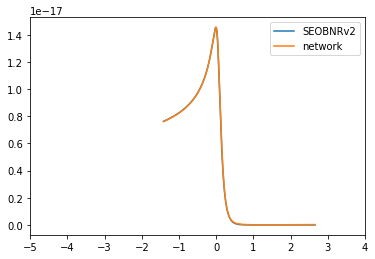

In [12]:
r = 2.73 # this precise value of r is not in the training dataset
M1 = 431
M2 = r * M1
hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                            mass1=M1,
                            mass2=M2,
                            delta_t=1e-3,
                            f_lower=2.0)
amps = waveform.utils.amplitude_from_polarizations(hp, hc)
predicted_amps = predict_amplitude(amps.sample_times, M1, M2, amplitude_network)

plt.plot(amps.sample_times, amps, label="SEOBNRv2")
plt.plot(amps.sample_times, predicted_amps, label="network")
plt.legend()
plt.xlim(-5, 4)

(-80.0, 1.0)

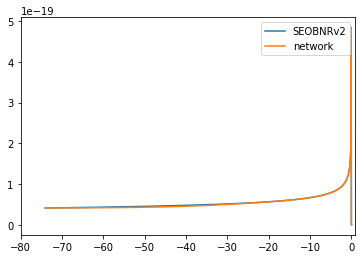

In [13]:
r = 1.05 # this precise value of r is not in the training dataset
M1 = 20
M2 = r * M1
hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                            mass1=M1,
                            mass2=M2,
                            delta_t=1e-3,
                            f_lower=5.0)
amps = waveform.utils.amplitude_from_polarizations(hp, hc)
predicted_amps = predict_amplitude(amps.sample_times, M1, M2, amplitude_network)

plt.plot(amps.sample_times, amps, label="SEOBNRv2")
plt.plot(amps.sample_times, predicted_amps, label="network")
plt.legend()
plt.xlim(-80, 1.0)

## Train a network on the phase data

In [14]:
data = GWDataset(phase_curves)
train = torch.utils.data.DataLoader(data, batch_size=500, shuffle=True)
train_copy = torch.utils.data.DataLoader(data, batch_size=500, shuffle=True)

In [15]:
WIDTH = 50
phase_network = nn.Sequential(
    nn.Linear(2, WIDTH),
    nn.Tanh(),
    nn.Linear(WIDTH, WIDTH),
    nn.Tanh(),
    nn.Linear(WIDTH, WIDTH),
    nn.Tanh(),
    nn.Linear(WIDTH, 1)
).to(device)

In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(phase_network.parameters())

In [17]:
for epoch in tqdm(range(15)):
    phase_network.train()
    for x, y in train:
        optimizer.zero_grad()
        loss = loss_fn(phase_network(x.to(device)), y.to(device))
        loss.backward()
        optimizer.step()
    
    phase_network.eval()
    with torch.no_grad():
        test_loss = 0
        num_samples = 0
        for x, y in islice(train_copy, 1000):
            test_loss += len(y) * loss_fn(phase_network(x.to(device)), y.to(device))
            num_samples += len(y)
        print("Epoch {0:3d} loss: {1:.7f}".format(epoch, test_loss / num_samples))


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch   0 loss: 152615.5175181
Epoch   1 loss: 56241.4481144
Epoch   2 loss: 16913.3743613
Epoch   3 loss: 3708.0644497
Epoch   4 loss: 450.1406687
Epoch   5 loss: 27.7902985
Epoch   6 loss: 2.7831719
Epoch   7 loss: 2.4142254
Epoch   8 loss: 0.5598501
Epoch   9 loss: 2.2912506
Epoch  10 loss: 0.2945060
Epoch  11 loss: 1.9091620
Epoch  12 loss: 0.3154218
Epoch  13 loss: 0.4717549
Epoch  14 loss: 0.2649245


(-5.0, 4.0)

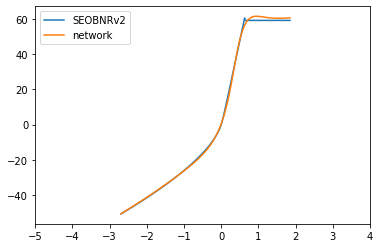

In [18]:
r = 1.57 # this precise value of r is not in the training dataset
M1 = 431
M2 = r * M1
hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                            mass1=M1,
                            mass2=M2,
                            delta_t=1e-3,
                            f_lower=2.0)
phase = waveform.utils.phase_from_polarizations(hp, hc)
phase = phase - phase.at_time(0)
predicted_phase = predict_phase(phase.sample_times, M1, M2, phase_network)

plt.plot(phase.sample_times, phase, label="SEOBNRv2")
plt.plot(phase.sample_times, predicted_phase, label="network")
plt.legend()
plt.xlim(-5, 4)

(-20.0, 4.0)

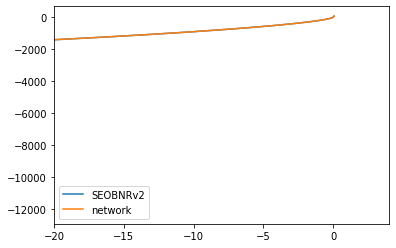

In [19]:
r = 1.57 # this precise value of r is not in the training dataset
M1 = 20
M2 = r * M1
hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                            mass1=M1,
                            mass2=M2,
                            delta_t=1e-3,
                            f_lower=2.0)
phase = waveform.utils.phase_from_polarizations(hp, hc)
phase = phase - phase.at_time(0)
predicted_phase = predict_phase(phase.sample_times, M1, M2, phase_network)

plt.plot(phase.sample_times, phase, label="SEOBNRv2")
plt.plot(phase.sample_times, predicted_phase, label="network")
plt.legend()
plt.xlim(-20, 4)